# Tweet Sentiment Analysis for Top Tech Brands

authored by Daniel Castelone

The purpose of this project is to develop a machine learning model using multinomial logistic regression to classify text-based social media posts based on their perceived sentimental affect. The model will be trained, tested, and used on data from 
[here](https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020) which contains over 4,000,000 tweets from the years 2015 to 2019 associated with Tesla, Amazon, Apple, Microsoft, and Google. The resulting application will allow the user to enter in their own text to be classified by the machine learning model. Further, a series of data visualizations will be created showing the net daily Twitter sentiment for the above mentioned companies plotted against daily stock volume traded. These are included to demonstrate the relationship between volume of shares traded and excessive social media sentiment on any particular day.


### Scroll to the bottom of the page to use the predictive widgets.

In [3]:
# The below libraries were used to process the data, create the model, and visualize the results.

%matplotlib inline
import pandas as pd
import re
import numpy
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import IPython
import ipywidgets as widgets
import yfinance as yf
from datetime import datetime
from ipywidgets import *
from IPython.display import display, clear_output
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer

In [2]:
#This block represents how the source data was initially transformed. 
#It's not currently in use in order to save computational resources when deploying the web app.
#While total counts reflect the full dataset, machine learning operations will be performed on a sample (500k tweets).


#df = pd.read_csv('Tweet.csv') # This file contains, primarily, the body text of each tweet.
#df2 = pd.read_csv('Company_Tweet.csv') # This file connects each tweet with its associated tech company.
#dfr = pd.merge(df, df2, how='inner', on='tweet_id')

#Here, the ordinal representation of the post_datetime is converted.
#dfr['post_datetime'] = pd.to_datetime(dfr['post_date'], unit='s') 
#dfr['month'] = dfr['post_datetime'].dt.strftime('%Y-%m')
#dfr['date'] = dfr['post_datetime'].dt.strftime('%Y-%m-%d')

# Columns that are not necessary for this project are dropped.
#dfr.drop(columns=['post_datetime', 'post_date', 'writer', 'comment_num', 'retweet_num', 'like_num'], inplace=True)

## Unclassified Tweet Counts

The total tweet count associated with each ticker symbol from the full dataset is shown in the table below. The proportions are visualized in the pie chart.

In [4]:
# This file contains the total amount of tweets per month associated with a particular brand.
mcounts = pd.read_csv('monthcounts.csv')
# The total number of tweets per company.
mcounts.groupby(['ticker_symbol'])['counts'].sum()

ticker_symbol
AAPL     1425013
AMZN      718715
GOOG      392569
GOOGL     327569
MSFT      375711
TSLA     1096868
Name: counts, dtype: int64

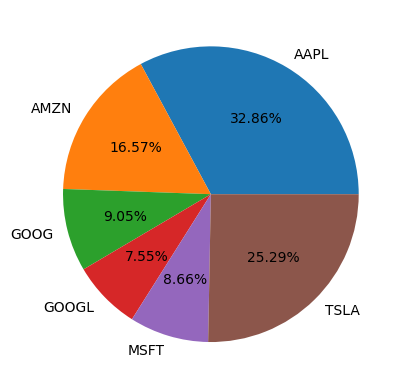

In [5]:
# This pie chart shows the breakdown of the entire dataset by associated brand.
counts = mcounts.groupby(['ticker_symbol'])['counts'].sum()
plt.pie(counts, autopct='%1.2f%%', labels=['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA'] )
plt.show()

## Tweet Count per Month

These are the total tweets, before any classification is applied, associated with a particular brand for each month during the recorded period.

In [6]:
# Set the style for the visualizations.
sns.set_style('whitegrid')
sns.set_context("notebook")

In [7]:
# This function will be used to graph the single-line charts below based the values for 'ticker' and 'color' parameters.

def graph_counts(ticker, color):
    
    df =  mcounts.loc[(mcounts['ticker_symbol'] == ticker), ['ticker_symbol', 'month', 'counts']]
    dct = sns.lineplot(
        data = df,
        x = 'month',
        y = 'counts',
        color = color,)

    ticker = str(df.at[df.index[1], 'ticker_symbol'])

    dct.set(xlabel = "Month", ylabel = "Number of Tweets", title = f"{ticker} Tweet Counts by Month")

    for label in dct.get_xticklabels():
        t = label.get_text()
        if t[-2:] == "12" or t[-2:] == "06" or t == "2015-01":
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.xticks(rotation=90)
    plt.show()



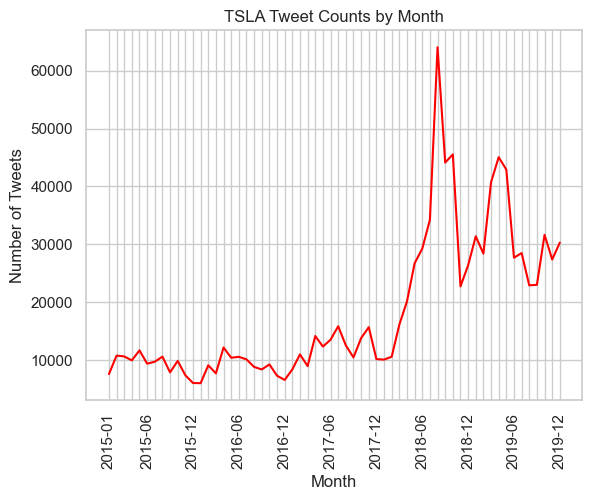

In [8]:
# The graphs below visualize the total unclassifed tweet count per month for each brand.

graph_counts('TSLA', 'red')

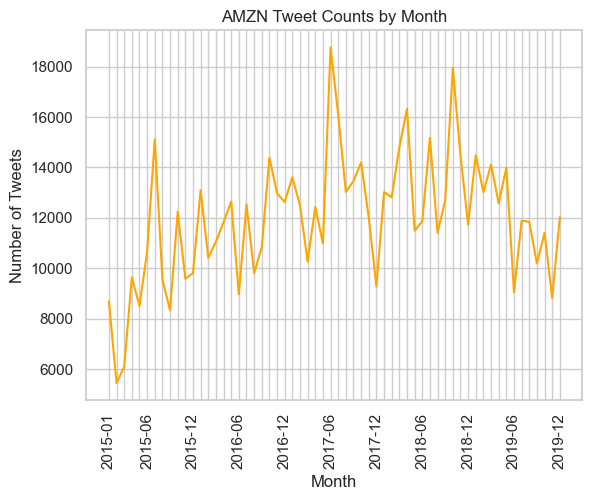

In [9]:
graph_counts('AMZN', 'orange')

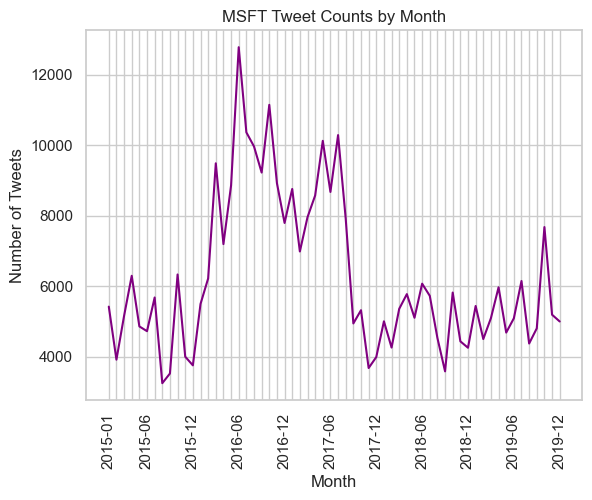

In [10]:
graph_counts('MSFT', 'purple')

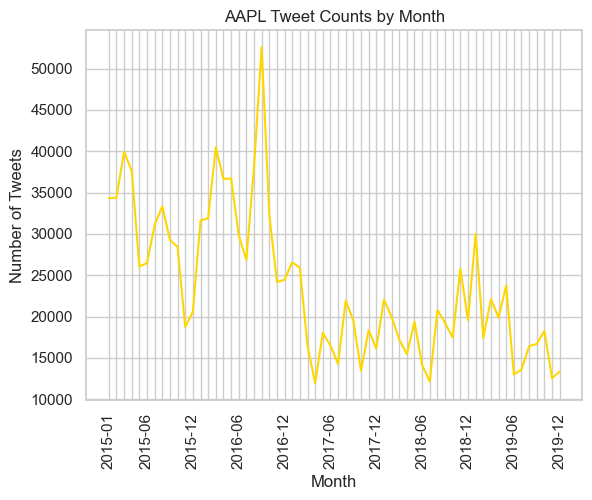

In [11]:
graph_counts('AAPL', 'gold')

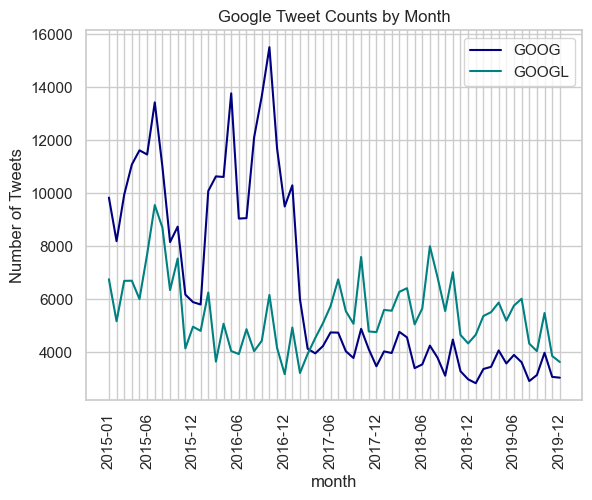

In [12]:
# This cell will visualize the totals for both ticker symbols associated with Google (Alphabet, Inc).
# When Google restructured into Alphabet in October 2015, it was listed under two ticker symbols.

dcg = sns.lineplot(
    data = mcounts.loc[(mcounts['ticker_symbol'] == "GOOG"), ['ticker_symbol', 'month', 'counts']],
    x = 'month',
    y = 'counts',
    color = 'navy',
    label = 'GOOG')

dcgl = sns.lineplot(
    data = mcounts.loc[(mcounts['ticker_symbol'] == "GOOGL"), ['ticker_symbol', 'month', 'counts']],
    x = 'month',
    y = 'counts',
    color = 'teal',
    label = 'GOOGL')

dcg.set(ylabel = "Number of Tweets", title = "Google Tweet Counts by Month")


for label in dcg.get_xticklabels():
    t = label.get_text()
    if t[-2:] == "12" or t[-2:] == "06" or t == "2015-01":
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=90)
plt.show()

In [22]:
stop_words = "i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't".split(",")
stemmer = PorterStemmer()

def process_tweet(input_tweet):
    
    tweet = str(input_tweet).lower()
    tweet = re.sub(r'\$\w*', ' ', tweet) # This removes any ticker symbols written with the $ symbol
    tweet = re.sub(r'\bhttps?://\S+\b', ' ', tweet) # This removes hyperlinks
    tweet = re.sub(r'(tesla|apple|microsoft|google|alphabet|amazon|goog|googl|msft|aapl|tsla|amzn)',' ', tweet)
                    # This removes the names and symbols of all the brands we are studying
    tweet = re.sub(r'(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\b[A-Za-z]\b)',' ',tweet)
                    # This removes all the mentions, special characters/numbers, and single-letter words
       
    words = []
  
    # This block filters stop words, then stems and returns the remaining words.
    for word in tweet.split():
        if word not in stop_words:
            stem_word = stemmer.stem(word)
            words.append(stem_word) #
    
    ptweet = ' '.join(words)
    
    return ptweet


In [25]:
# The training and test data sets were developed by manually scoring a sample of tweets from the full dataset.
# The Training/Testing data was split approximately 70%-30%. Of both these sets, the majority neutral class makes up about 85%, and the tweets classified as positive or negative split the remainder roughly equally.
# The classification is as follows: 0 corresponds to neutral, -1 to negative, and 1 to positive.
training = pd.read_csv('Training.csv')
testing = pd.read_csv('Testing.csv')

In [26]:
# The body text is processed.
training['body'] = training['body'].map(process_tweet)
testing['body'] = testing['body'].map(process_tweet)

In [27]:
# Instantiate the vectorizer.
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,1)) #The strings are already lowercase. 1 word n-grams are used.
xtrain = vectorizer.fit_transform(training['body']) # The processed text is set as our training x-value.
ytrain = training['flag'] # The manually-scored sentiment classification is set as our training y-value.

In [28]:
# The testing x and y values are set. 
xtest = vectorizer.transform(testing['body'])
ytest = testing['flag']

In [30]:
# This function creates our model and prints its accuracy.
def train_model(xtrain, ytrain, xtest, ytest, _C=20):
    model = LogisticRegression(
        penalty='l2',max_iter=300,class_weight={-1:1.0, 0:0.125, 1:1.0},C=_C,solver='saga', multi_class='auto').fit(xtrain, ytrain)
    score = model.score(xtest, ytest)
    #print(score)
    return model

In [31]:
# The model scores about 81% accuracy. Uncomment the print block in the previous cell to confirm.
model = train_model(xtrain, ytrain, xtest, ytest)

0.808688387635756


In [ ]:
# Now that the model is created, we can define a function to vectorize and classify text input.
def classify_text(model, vectorizer, text):
    v = vectorizer.transform(text)
    flags = model.predict(v)
    return flags

In [ ]:
#To reduce computational costs during demonstration to users, the model will be applied only to 250k tweets.
source = pd.read_csv('limiteddataset.csv')
source.drop(columns=['month'], inplace=True)
source.reset_index(drop=True, inplace=True)

In [ ]:
# A new column is created for the processed text. 
# The model is applied to the dataset and a flag is predicted for each tweet.
source['body_processed'] = source['body'].map(process_tweet)
spredict = source['body_processed']
source['flag'] = classify_text(model, vectorizer, spredict)

In [ ]:
# This dataframe holds all the non-neutral tweets.
sourcef = source.loc[(source['flag'] == -1) | (source['flag'] == 1), 
                     ['tweet_id', 'body', 'body_processed', 'ticker_symbol', 'date', 'flag']]

## Classified Totals

This pie chart depicts the total of all emotional (positive or negative) tweets grouped by brand as rated by the machine learning mode.

In [ ]:
# A numerical representation of the non-neutral tweet counts by ticker symbol.
countsf = sourcef.groupby(['ticker_symbol'])['tweet_id'].count()

In [ ]:
# The above visualized as a pie chart.
plt.pie(countsf, autopct='%1.2f%%', labels=['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA'] )
plt.show()

In [ ]:
# This dataframe calculates the net daily sentiment.
flagtotals = source.groupby(['ticker_symbol','date'])['flag'].sum()
flagtotals.to_csv('flagtotals.csv')
flagtotals = pd.read_csv('flagtotals.csv')

##  Net Twitter Sentiment vs Volume Traded
The graphs below plot the net sentiment value on the left y-axis, and the volume of shares traded on the right y-axis, per day. The graphs are included to support the argument that social media sentiment reflects useful business & marketing information.

In [ ]:
# This function joins the Yahoo Finance dataframe to the flagtotals dataframe and drops unnecessary columns.
def join_finance(dfa, dfb):
    dfa.reset_index(inplace=True)
    dfa['Date'] = dfa['Date'].dt.strftime("%Y-%m-%d")
    dfa.rename(columns={'Date':'date'}, inplace=True)
    dfa.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Close'], inplace=True)
    dfc = pd.merge(dfb, dfa, how='left', on='date')
    return dfc

In [ ]:
# This function graphs net daily sentiment vs volume traded per day based on the arguments for ticker symbol and color.
def graph_combined(ticker, col):
    
    start = "2015-01-01"
    end = "2020-01-01"

    
    dff = flagtotals.loc[(flagtotals['ticker_symbol'] == ticker), ['ticker_symbol', 'date', 'flag']]
    dfyf = yf.download(ticker, start, end, progress=False)
    df = join_finance(dfyf, dff)
    
    
    x = df['date']
    y = df['flag']
    y2 = df['Volume']

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.barplot(x=x, y=y, ax=ax1, color = col, lw=0)
    sns.lineplot(x=x, y=y2, color = 'green', ax=ax2, lw=0.25)
    
    ticker = str(df.at[df.index[1],'ticker_symbol'])
    ax1.set_title(f'{ticker} Net Sentiment and Volume Traded per Day')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Net Daily Sentiment', color = col)
    ax2.set_ylabel('Volume Traded (1e8)', color = 'green')

    for label in ax1.get_xticklabels():
        t = label.get_text()
        if t[-5:] == "12-31" or t=="2015-01-01":
            label.set_visible(True)
        else:
            label.set_visible(False)

plt.show()

In [ ]:
# The graphs show a correlation between net daily sentiment and volume traded that could be useful in a marketing context.
graph_combined('TSLA', 'red')

In [ ]:
graph_combined('AMZN', 'orange')

In [ ]:
graph_combined('MSFT', 'purple')

In [ ]:
graph_combined('AAPL', 'gold')

In [ ]:
graph_combined('GOOG', 'navy')

In [ ]:
graph_combined('GOOGL', 'teal')

## Predictive Widgets

Two interactive widgets are included that can provide predictive value using the machine learning model. The first takes in any number of comma separated strings and returns a piechart showing their sentiment distribution as well as their net sentiment value. 

The second widget updates in real time as one string is enter into the text box. It provides sentiment classification for any one string on the fly.

In [ ]:
# This function processes a list of strings, applies the model, prints the net sentiment, and plots a pie chart of their values.
def process_given(strings):
    global i
    df = pd.DataFrame(strings, columns=['raw'])
    df['processed'] = df['raw'].apply(process_tweet)
    predict = df['processed']
    df['Sentiment'] = classify_text(model, vectorizer, predict)
    value = df['Sentiment'].sum()
    di = {-1:'Negative', 0:'Neutral', 1:'Positive'}
    df['Sentiment'].replace(di, inplace=True)
    with output:
        clear_output(wait=True)
        plot = df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.2f%%', labels = None, legend=True,
                                                  title = f'Set #{i}: Net Sentiment Value: {value}')
        i +=1
        plt.show()
i = 1   

output = widgets.Output()
    
inputbox = widgets.Textarea(
    value = "Enter any number of strings separated by commas, then click the button below.")

go_button = widgets.Button(
    description = "Go!",
    icon = "check",
    button_style = "success")

def on_button_clicked(b):
    string = inputbox.value
    if len(string) >= 1:
        strings = string.split(",")
        process_given(strings)
        
        
go_button.on_click(on_button_clicked)


# CSV Classification Widget
display(inputbox)
display(go_button)
display(output)

In [ ]:
#Interactive Textbox Widget
@interact
def take_text(tweet =''):
    tweet = [process_tweet(tweet)]
    result = classify_text(model, vectorizer, tweet)
    if result == [1]:
        print('Your message is positive.')
    if result == [-1]:
        print ('Your message is negative.')
    if result == [0]:
        print ('Your message is neutral.')